## Before anything please install all needed requirements via the below commands
`conda create --name <envname> --file requirements.txt`
<br />
`conda activate <envname>`

# Fine Tuning Transformer for MultiLabel Text Classification

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Pytorch Lightning
* Transformers
* BERT Model and Tokenizer

Followed by that we will preapre the device for GPU execeution. This configuration is needed if you want to leverage on onboard GPU. 

In [1]:
# Importing stock ml libraries
import os

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoModelForMaskedLM




import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 1995

os.environ["CUDA_VISIBLE_DEVICES"]="1"

pl.seed_everything(RANDOM_SEED)

Global seed set to 1995


1995

In [2]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
print(device)

cuda


<a id='section02'></a>
### Importing and Pre-Processing the Patent data



In [4]:
df_2006 = pd.read_json('/home/chikkamath/uspto_2m/2006_USPTO.json')
df_2007 = pd.read_json('/home/chikkamath/uspto_2m/2007_USPTO.json')
df_2008 = pd.read_json('/home/chikkamath/uspto_2m/2008_USPTO.json')
df_2009 = pd.read_json('/home/chikkamath/uspto_2m/2009_USPTO.json')
df_2010 = pd.read_json('/home/chikkamath/uspto_2m/2010_USPTO.json')
df_2011 = pd.read_json('/home/chikkamath/uspto_2m/2011_USPTO.json')
df_2012 = pd.read_json('/home/chikkamath/uspto_2m/2012_USPTO.json')
df_2013 = pd.read_json('/home/chikkamath/uspto_2m/2013_USPTO.json')
df_2014 = pd.read_json('/home/chikkamath/uspto_2m/2014_USPTO.json')
df_2015 = pd.read_json('/home/chikkamath/uspto_2m/2015_USPTO.json')



df = pd.concat([df_2006, df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015], axis=0, ignore_index=True)

In [5]:
df.head()

,Subclass_labels,Abstract,Title,No
0,[G11B],a magnetic disc unit having a rotating disc ty...,magnetic disc unit with range of gap between d...,US07072141
1,[A41D],methods and systems for transforming a volume ...,systems and methods for transformable suits,US06981282
2,[A41D],a gardening glove or the like designed to prev...,gardening gloves with cushion insert to protec...,US06981283
3,[A63B],a hockey helmet for receiving a head of a wear...,hockey helmet comprising a lateral adjustment ...,US06981284
4,[E03D],a toilet and toilet system suitable for a boat...,toilet and method of operation,US06981285


# of lables is: 633


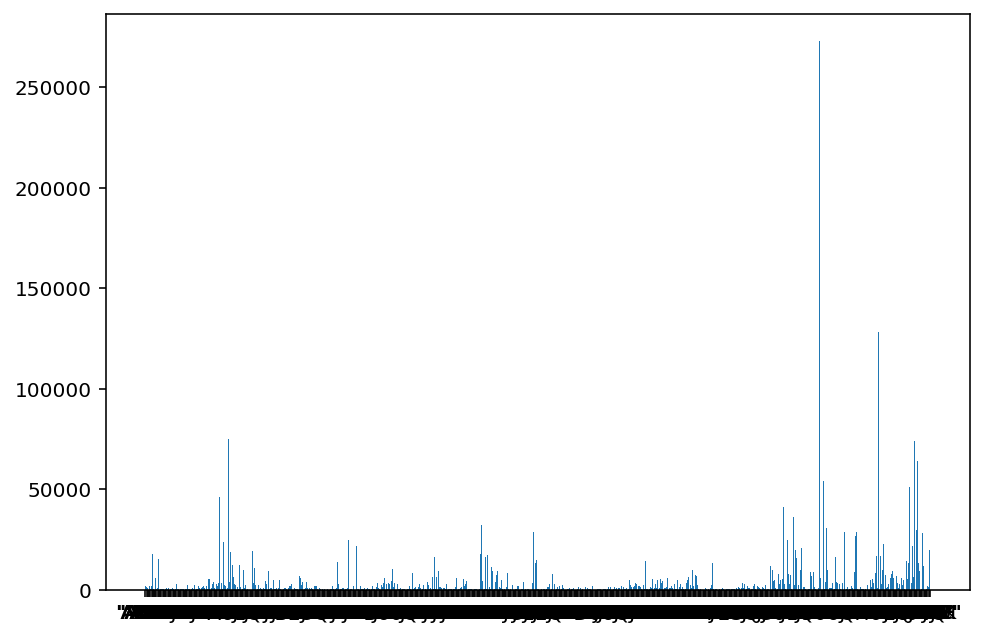

In [6]:
labels = str(df.iloc[:len(df)-len(df_2015)]['Subclass_labels'].tolist()).replace('[', '').replace(']', '').replace(' ', '').split(',')


val, counts = np.unique(labels, return_counts=True)

print('# of lables is: '+str(len(val)))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(val,counts)
plt.show()

# of lables is: 606


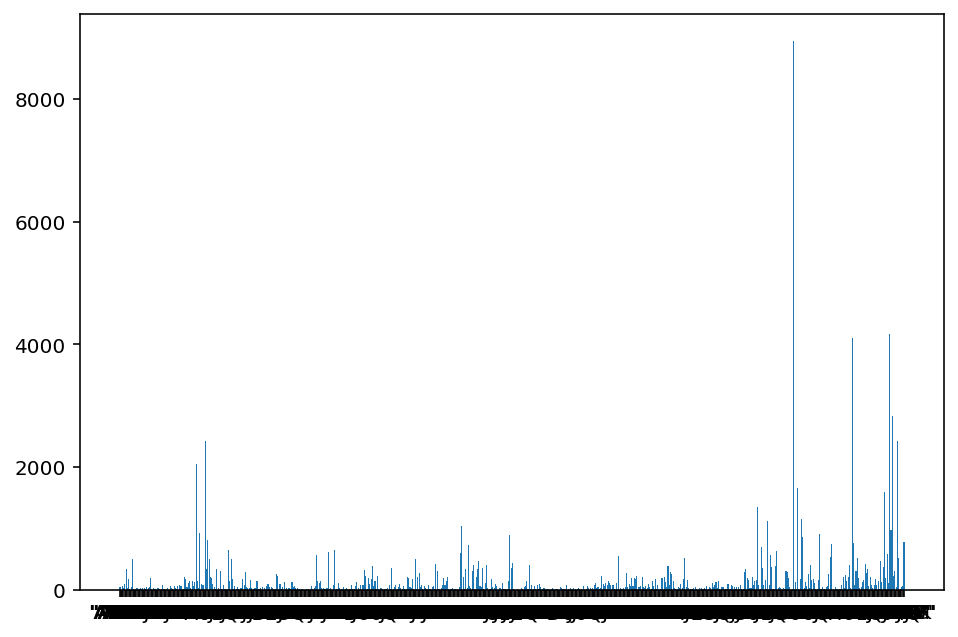

In [7]:
labels = str(df_2015['Subclass_labels'].tolist()).replace('[', '').replace(']', '').replace(' ', '').split(',')


val, counts = np.unique(labels, return_counts=True)

print('# of lables is: '+str(len(val)))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(val,counts)
plt.show()

In [8]:
print(df.shape)
df.head()

(2000147, 4)


,Subclass_labels,Abstract,Title,No
0,[G11B],a magnetic disc unit having a rotating disc ty...,magnetic disc unit with range of gap between d...,US07072141
1,[A41D],methods and systems for transforming a volume ...,systems and methods for transformable suits,US06981282
2,[A41D],a gardening glove or the like designed to prev...,gardening gloves with cushion insert to protec...,US06981283
3,[A63B],a hockey helmet for receiving a head of a wear...,hockey helmet comprising a lateral adjustment ...,US06981284
4,[E03D],a toilet and toilet system suitable for a boat...,toilet and method of operation,US06981285


In [6]:
new_df = df.copy()
new_df.head()

,Subclass_labels,Abstract,Title,No
0,[G11B],a magnetic disc unit having a rotating disc ty...,magnetic disc unit with range of gap between d...,US07072141
1,[A41D],methods and systems for transforming a volume ...,systems and methods for transformable suits,US06981282
2,[A41D],a gardening glove or the like designed to prev...,gardening gloves with cushion insert to protec...,US06981283
3,[A63B],a hockey helmet for receiving a head of a wear...,hockey helmet comprising a lateral adjustment ...,US06981284
4,[E03D],a toilet and toilet system suitable for a boat...,toilet and method of operation,US06981285


In [7]:
abstracts = new_df.Abstract.values
titles = new_df.Title.values

for i in range(len(abstracts)):
    abstracts[i] = titles[i] + ' : ' + abstracts[i]
    

new_df.Abstract = abstracts

y = new_df['Subclass_labels'].values
mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform(y)
new_df['Subclass_labels'] = y_binarized.tolist()

new_df.head()

,Subclass_labels,Abstract,Title,No
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",magnetic disc unit with range of gap between d...,magnetic disc unit with range of gap between d...,US07072141
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",systems and methods for transformable suits : ...,systems and methods for transformable suits,US06981282
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",gardening gloves with cushion insert to protec...,gardening gloves with cushion insert to protec...,US06981283
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",hockey helmet comprising a lateral adjustment ...,hockey helmet comprising a lateral adjustment ...,US06981284
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",toilet and method of operation : a toilet and ...,toilet and method of operation,US06981285


In [9]:
LABEL_COLUMNS = mlb.classes_
LABEL_COLUMNS
print(len(LABEL_COLUMNS))

632


In [10]:
new_df = new_df[['Abstract', 'Subclass_labels']].copy()
new_df.head()

,Abstract,Subclass_labels
0,magnetic disc unit with range of gap between d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,systems and methods for transformable suits : ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,gardening gloves with cushion insert to protec...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,hockey helmet comprising a lateral adjustment ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,toilet and method of operation : a toilet and ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
print("Average text length is: "+str(sum(new_df.Abstract.apply(lambda x: len(x.split())))/len(new_df)))
print("Max text lenght is : "+str(max(new_df.Abstract.apply(lambda x: len(x.split())))))

Average text length is: 118.42944143605445
Max text lenght is : 515


### Text length distribution

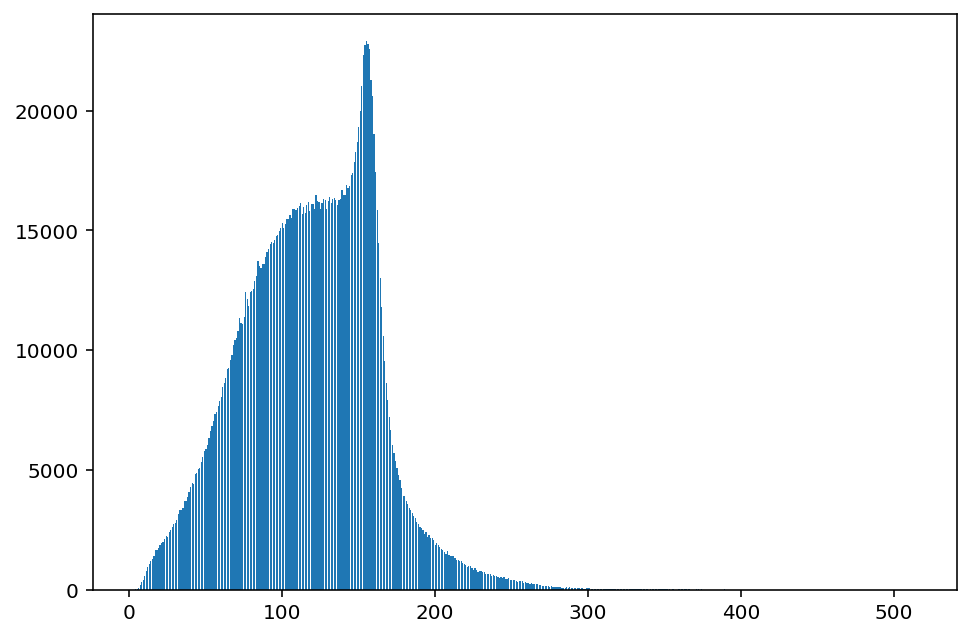

In [14]:
length = new_df.Abstract.apply(lambda x: len(x.split()))
                      

val, counts = np.unique(length, return_counts=True)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(val,counts)
plt.show()

<a id='section03'></a>
### Preparing the Dataset and Dataloader


#### *CustomDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT model for training. 
- We are using the BERT tokenizer to tokenize the data in the `comment_text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`
---
- *This is the first difference between the distilbert and bert, where the tokenizer generates the token_type_ids in case of Bert*
---
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer)
- `targest` is the list of categories labled as `0` or `1` in the dataframe. 
- The *CustomDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset 2006-2014* is used to fine tune the model
- *Validation Dataset 2015* is used to evaluate the performance of the model. The model has not seen this data during training. 

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [11]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 128
EPOCHS = 4
LEARNING_RATE = 3e-05

BERT_MODEL_NAME = 'anferico/bert-for-patents'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [12]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = self.data.Abstract
        self.targets = self.data.Subclass_labels
        self.max_len = max_len
        try:
            self.title = dataframe.Title
        except:
            self.title = None

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        
        try:
            tokenized_text = {}
            text = str(self.text[index])
            text = " ".join(text.split())
            if self.title is not None:
                title = str(self.title[index])
                title = " ".join(title.split())

                inputs = self.tokenizer.encode_plus(
                title,
                None,
                add_special_tokens=True,
                max_length=self.max_len,
                pad_to_max_length=True,
                return_token_type_ids=True
                )

                ids = inputs['input_ids']
                mask = inputs['attention_mask']
                token_type_ids = inputs["token_type_ids"]


                tokenized_text = {
                    'ids_title': torch.tensor(ids, dtype=torch.long),
                    'mask_title': torch.tensor(mask, dtype=torch.long),
                    'token_type_ids_title': torch.tensor(token_type_ids, dtype=torch.long),
                }

            inputs = self.tokenizer.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=self.max_len,
                pad_to_max_length=True,
                return_token_type_ids=True
            )
            ids = inputs['input_ids']
            mask = inputs['attention_mask']
            token_type_ids = inputs["token_type_ids"]



            tokenized_text['input_ids'] = torch.tensor(ids, dtype=torch.long)
            tokenized_text['attention_mask'] = torch.tensor(mask, dtype=torch.long)
            tokenized_text['token_type_ids'] = torch.tensor(token_type_ids, dtype=torch.long)
            tokenized_text['labels'] = torch.tensor(self.targets[index], dtype=torch.float)
        except:
            pass
        return tokenized_text
        

In [13]:
class PatentDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = CustomDataset(
          self.train_df,
          self.tokenizer,
          self.max_token_len
        )

        self.test_dataset = CustomDataset(
          self.test_df,
          self.tokenizer,
          self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size=self.batch_size,
          shuffle=True,
          num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
          self.test_dataset,
          batch_size=self.batch_size,
          num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
          self.test_dataset,
          batch_size=self.batch_size,
          num_workers=2
        )

In [14]:
# Creating the dataset and dataloader for the neural network


train_dataset = new_df.iloc[:len(df)-len(df_2015)]
test_dataset = new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (2000147, 2)
TRAIN Dataset: (1950247, 2)
TEST Dataset: (49900, 2)


In [15]:
BATCH_SIZE = 54

data_module = PatentDataModule(
  train_dataset,
  test_dataset,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_LEN
)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `BERTClass`. 
 - This network will have the `Bert` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively. 
 - In the forward loop, there are 2 output from the `BertModel` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`. 
 - Keep note the number of dimensions for `Linear Layer` is **6** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `BertClass` as defined in the dataset. 
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.
 
#### Further Reading
- You can refer to my [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials) to get an intuition of Loss Function and Optimizer.
- [Pytorch Documentation for Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Pytorch Documentation for Optimizer](https://pytorch.org/docs/stable/optim.html)
- Refer to the links provided on the top of the notebook to read more about `BertModel`. 

In [16]:
class PatentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    
    
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

#   def training_epoch_end(self, outputs):
    
#     labels = []
#     predictions = []
#     for output in outputs:
#       for out_labels in output["labels"].detach().cpu():
#         labels.append(out_labels)
#       for out_predictions in output["predictions"].detach().cpu():
#         predictions.append(out_predictions)

#     labels = torch.stack(labels).int()
#     predictions = torch.stack(predictions)

#     for i, name in enumerate(LABEL_COLUMNS):
#       class_roc_auc = auroc(predictions[:, i], labels[:, i])
#       self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [17]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


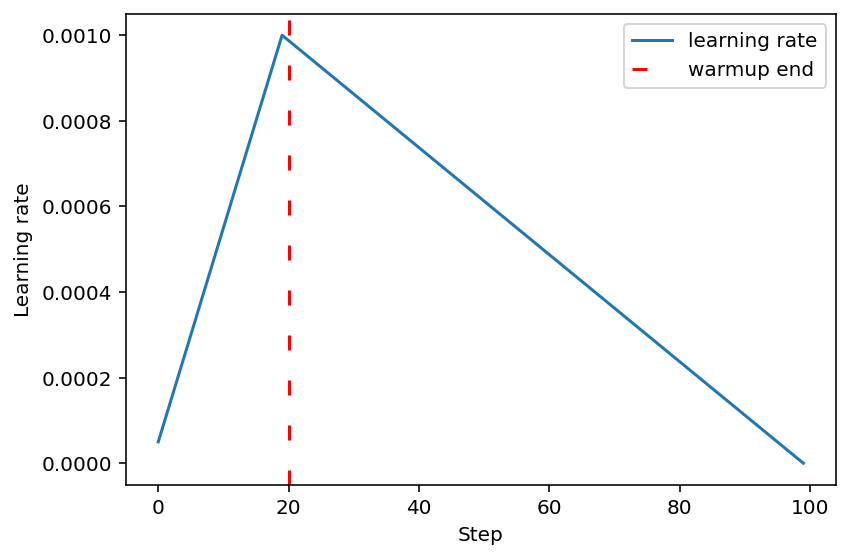

In [18]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [19]:
steps_per_epoch=len(train_dataset) // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS

In [20]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(28892, 144460)

In [21]:
model = PatentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
# !rm -rf lightning_logs/
# !rm -rf checkpoints/

In [24]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs_uspto

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 594298), started 0:00:37 ago. (Use '!kill 594298' to kill it.)

In [25]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints_uspto",
  filename="best-checkpoint_uspto",
  save_top_k=1,
  verbose=True,
  monitor="train_loss",
  mode="min"
)

In [26]:
logger = TensorBoardLogger("lightning_logs_uspto", name="patent-tagger_uspto")

In [27]:
early_stopping_callback = EarlyStopping(monitor='train_loss', patience=5)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

In [ ]:
trainer.fit(model, datamodule=data_module)

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model. 

As defined above to get a measure of our models performance we are using the following metrics. 
- Accuracy Score
- F1 Micro
- F1 Macro

We are getting amazing results for all these 3 categories just by training the model for 1 Epoch.

## Threshold

In [ ]:
print(trainer.checkpoint_callback.best_model_path)

trained_model = PatentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
#   checkpoint_path="lightning_logs_uspto/patent-tagger_uspto/version_3/checkpoints/epoch=2-step=182838.ckpt",
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)


predictions = []
labels = []

for item in tqdm(testing_set):
    _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())


In [34]:
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [35]:
print("AUROC per tag")
aurocs = []
for i, name in enumerate(LABEL_COLUMNS):
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    aurocs.append(tag_auroc)
    print(f"{name}: {tag_auroc}")

AUROC per tag
A01B: 0.9695453643798828
A01C: 0.9977090358734131
A01D: 0.9916242361068726
A01F: 0.998645007610321
A01G: 0.9852432012557983
A01H: 0.9989899396896362
A01J: 0.9905205965042114
A01K: 0.9816715717315674
A01L: 0.8946107625961304
A01M: 0.997225284576416
A01N: 0.9850311279296875
A01P: 0.9985966682434082
A21B: 0.9996191263198853
A21C: 0.9975697994232178
A21D: 0.9913384914398193
A22B: 0.9987013339996338
A22C: 0.9991591572761536
A23B: 0.9891166090965271
A23C: 0.987835168838501
A23D: 0.9987869262695312
A23F: 0.9987823963165283
A23G: 0.9877661466598511
A23J: 0.9982509613037109
A23K: 0.9931793808937073
A23L: 0.9898450970649719
A23N: 0.9983991980552673
A23P: 0.9871326684951782
A24B: 0.9997594356536865
A24C: 0.9917291402816772
A24D: 0.9963380098342896
A24F: 0.9942376613616943
A41B: 0.9966639280319214
A41C: 0.999945878982544
A41D: 0.9964187145233154
A41F: 0.9918400049209595
A41G: 0.9932504296302795
A41H: 0.9824761152267456
A42B: 0.9986728429794312
A42C: 0.9998596906661987
A43B: 0.9950720

/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


A99Z: 0.0
B01B: 0.9397069215774536
B01D: 0.9886772036552429
B01F: 0.9759241938591003
B01J: 0.9866063594818115
B01L: 0.9963358640670776
B02B: 0.9969437718391418
B02C: 0.989604115486145
B03B: 0.9729204177856445
B03C: 0.9929056763648987
B03D: 0.9977810978889465
B04B: 0.9717696905136108
B04C: 0.9962379932403564
B05B: 0.9871518611907959
B05C: 0.9899568557739258
B05D: 0.977256178855896
B06B: 0.9860114455223083
B07B: 0.9953864812850952
B07C: 0.9941509962081909
B08B: 0.9892493486404419
B09B: 0.9810971021652222
B09C: 0.9894115924835205
B21B: 0.9927363395690918
B21C: 0.9891000986099243
B21D: 0.9797080159187317
B21F: 0.9974251985549927
B21G: 0.0
B21H: 0.9988911151885986
B21J: 0.9869222640991211
B21K: 0.9922511577606201
B21L: 0.9999197721481323
B22C: 0.9878286123275757
B22D: 0.9863158464431763
B22F: 0.9898468255996704
B23B: 0.9816031455993652
B23C: 0.9879614114761353
B23D: 0.985003650188446
B23F: 0.9993706941604614
B23G: 0.9999098181724548
B23H: 0.9726966619491577
B23K: 0.9876927137374878
B23P: 0.

In [36]:
print(f"Average AUROC is {sum(aurocs)/len(aurocs)}")

Average AUROC is 0.9452142119407654


In [54]:
THRESHOLD = 0.9

In [55]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0,
    digits=4
))

              precision    recall  f1-score   support

        A01B     0.0000    0.0000    0.0000        50
        A01C     1.0000    0.3256    0.4912        43
        A01D     1.0000    0.2787    0.4359        61
        A01F     0.0000    0.0000    0.0000        24
        A01G     1.0000    0.1379    0.2424        87
        A01H     1.0000    0.8187    0.9003       342
        A01J     1.0000    0.1053    0.1905        19
        A01K     0.9481    0.4220    0.5840       173
        A01L     0.0000    0.0000    0.0000         4
        A01M     1.0000    0.2889    0.4483        45
        A01N     1.0000    0.0922    0.1688       499
        A01P     0.0000    0.0000    0.0000        17
        A21B     0.0000    0.0000    0.0000        14
        A21C     0.0000    0.0000    0.0000        18
        A21D     0.0000    0.0000    0.0000        24
        A22B     0.0000    0.0000    0.0000         5
        A22C     0.0000    0.0000    0.0000        18
        A23B     0.0000    

## Top@

In [64]:
K = 5
pred = torch.zeros_like(predictions)
_, top_k = torch.topk(predictions, K)

pred = pred.numpy()
top_k = top_k.numpy()
np.put_along_axis(pred, top_k, 1, axis=1)

In [65]:
y_pred = pred
y_true = labels.numpy()


print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0,
    digits=4
))

              precision    recall  f1-score   support

        A01B     0.1737    0.6600    0.2750        50
        A01C     0.4359    0.7907    0.5620        43
        A01D     0.4074    0.7213    0.5207        61
        A01F     0.3800    0.7917    0.5135        24
        A01G     0.3111    0.6437    0.4195        87
        A01H     0.8524    0.9795    0.9116       342
        A01J     0.4444    0.4211    0.4324        19
        A01K     0.4819    0.7688    0.5924       173
        A01L     0.5000    0.5000    0.5000         4
        A01M     0.3837    0.7333    0.5038        45
        A01N     0.1982    0.8637    0.3224       499
        A01P     0.0989    0.5294    0.1667        17
        A21B     0.2449    0.8571    0.3810        14
        A21C     0.4348    0.5556    0.4878        18
        A21D     0.2571    0.3750    0.3051        24
        A22B     0.1667    0.6000    0.2609         5
        A22C     0.2692    0.7778    0.4000        18
        A23B     0.1905    